In [14]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [15]:
import sys
sys.path.append('/home/tiurin/projects/ExampleProject/Temp/eye_quality/')

In [16]:
#|export
DATASET_PATH = "/home/tiurin/projects/ExampleProject/Temp"

In [17]:
#|export
from torch.utils.data import Dataset, Subset
import torch
import torchvision
import numpy as np

In [18]:
#|export
import os, glob
import random

class EyeQDataset(Dataset):

    def __init__(self, dataset_path, transform=None):
        self.transform = transform
        self.data = []
        random.seed(42)
        if not isinstance(dataset_path, list):
            dataset_path = [dataset_path]
        for p in dataset_path:
            for i in range(3):
                class_i = [(2-i, im) for im in glob.glob(os.path.join(p, str(i), '*.png'))]
                self.data.extend(class_i)

    def __len__(self):
        return len(self.data)

    def get_labels(self):
        return [i[0] for i in self.data]

    def __getitem__(self, idx):
        quality_class, image_path = self.data[idx]
        sample = torchvision.io.read_image(image_path).to(torch.float32)
        sample /= 255.0

        if self.transform:
            sample = self.transform(sample)

        return quality_class, sample

In [19]:
#|export
import os, glob
import random

class EyeQDatasetDistorted(Dataset):

    def __init__(self, dataset_path, transform=None):
        self.transform = transform
        self.data = []
        random.seed(42)
        if not isinstance(dataset_path, list):
            dataset_path = [dataset_path]
        for p in dataset_path:
            for i in range(3):
                class_i = [im for im in glob.glob(os.path.join(p, str(i), '*.png'))]
                self.data.extend(class_i)

        self.distortion_transforms=[
            #torchvision.transforms.ElasticTransform(alpha=[50., 250.0], sigma=[2., 10.]),
            torchvision.transforms.Normalize((0.856), (0.224)),
            torchvision.transforms.RandomResizedCrop((400, 400), scale=(0.08, 0.5), ratio=(0.75, 1.3)),
            torchvision.transforms.ColorJitter(brightness=[0.5, 1.0], contrast=[0.5, 1.0], 
                                               saturation=[0.5, 1.0], hue=0.5),
            torchvision.transforms.GaussianBlur(kernel_size=9, sigma=(10.0, 15.0))
        ]
        
        self.probability_apply = 0.5
        
                
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        sample = torchvision.io.read_image(image_path).to(torch.float32)
        sample /= 255.0
        
        tnsfm = random.choice(self.distortion_transforms)
        sample = tnsfm(sample)
        
        for i in range(len(self.distortion_transforms)-1):
            if random.uniform(0, 1) > self.probability_apply:
                tnsfm = random.choice(self.distortion_transforms)
                sample = tnsfm(sample)
        
        if random.uniform(0, 1) > self.probability_apply:
            sample += torch.rand_like(sample)
        
        if self.transform:
            sample = self.transform(sample)

        return 0, sample

In [20]:
#|export
import os, glob
import random

class EyeQDatasetRejectClass(Dataset):

    def __init__(self, dataset_path, transform=None):
        self.transform = transform
        self.data = []
        random.seed(42)
        if not isinstance(dataset_path, list):
            dataset_path = [dataset_path]
        for p in dataset_path:
            class_i = [im for im in glob.glob(os.path.join(p, '*.*'))]
            self.data.extend(class_i)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        sample = torchvision.io.read_image(image_path).to(torch.float32)
        sample /= 255.0

        if self.transform:
            sample = self.transform(sample)

        return 0, sample

In [21]:
#|export
import os, glob
import random

class NoiseImages(Dataset):

    def __init__(self, dataset_size, image_size, transform=None):
        self.transform = transform
        self.dataset_size = dataset_size
        self.image_size = image_size
        random.seed(42)

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        sample = torch.randn(*self.image_size)
        
        if self.transform:
            sample = self.transform(sample)

        return 0, sample

In [22]:
#|export

def get_padding(image, height, width):
    max_w = width 
    max_h = height
    
    imsize = (image.size(1), image.size(2))
    h_padding = (max_w - imsize[0]) / 2
    v_padding = (max_h - imsize[1]) / 2
    l_pad = h_padding if h_padding % 1 == 0 else h_padding+0.5
    t_pad = v_padding if v_padding % 1 == 0 else v_padding+0.5
    r_pad = h_padding if h_padding % 1 == 0 else h_padding-0.5
    b_pad = v_padding if v_padding % 1 == 0 else v_padding-0.5
    
    padding = (int(l_pad), int(t_pad), int(r_pad), int(b_pad))
    
    return padding

In [23]:
#|export
import random
def zoom_augmentation(tensor):
    width = tensor.size(dim=2)
    height = tensor.size(dim=1)
    scale = random.uniform(0.6, 1)
    width_n = int(width*scale)
    height_n = int(height*scale)
    tensor = torchvision.transforms.functional.resize(tensor, (height_n, width_n))
    padding = get_padding(tensor, width, height)
    tensor = torchvision.transforms.functional.pad(tensor, padding)
    return tensor

In [24]:
#|export

from torch.utils.data import ConcatDataset

def get_dataset(train_percent = 0.9, rotation_transform=True, zoom_augment = True):
    
    transforms = []
    
    if rotation_transform:
        transforms.append(torchvision.transforms.RandomRotation(degrees=(0, 360)))
        
    transforms.append(torchvision.transforms.RandomHorizontalFlip(p=0.5))
    transforms.append(torchvision.transforms.RandomVerticalFlip(p=0.5))
    if zoom_augment:
        transforms.append(zoom_augmentation)
    transforms.append(torchvision.transforms.Resize((400,400)))
    transforms.append(torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1))
    transforms.append(torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.2)))
    transforms.append(torchvision.transforms.Normalize((0.456), (0.224)))
    
    transform = torchvision.transforms.Compose(transforms)
    
    dataset_paths = [os.path.join(DATASET_PATH, 'processed'),
                     os.path.join(DATASET_PATH, 'processed_test')]
    
    dataset = EyeQDataset(dataset_paths, transform=transform)
    
    dataset_noise = NoiseImages(1000, (1, 400,400), transform=transform)
    
    dataset_eye_distorted = EyeQDatasetDistorted(dataset_paths, transform=transform)
    
    lbls = np.asarray(dataset.get_labels())
    
    idx_train = []
    idx_val = []
    
    np.random.seed(42)
    for i in range(3):
        idx = np.where(lbls==i)[0]
        np.random.shuffle(idx)
        train_size = int(len(idx)*train_percent)
        val_size = len(idx)-train_size
        idx_train.extend(idx[:train_size].tolist())
        idx_val.extend(idx[train_size:].tolist())
    
    lbls = np.concatenate((lbls, 
                           np.asarray([0]*len(dataset_noise)),
                          np.asarray([0]*len(dataset_eye_distorted))))
    P = torch.bincount(torch.Tensor(lbls).to(torch.long))/len(dataset)
    class_weights = torch.sqrt(1/P)
    
    train_set = Subset(dataset, idx_train)
    
    train_set = ConcatDataset([train_set, dataset_noise, dataset_eye_distorted])
    
    val_set = Subset(dataset, idx_val)
    
    return train_set, val_set, class_weights

In [25]:
#|export
def normalize(tensor):
    return torchvision.transforms.functional.normalize(tensor,(0.456), (0.224))

In [26]:
#|export
def inverse_transform(tensor):
    tensor =  torchvision.transforms.functional.normalize(tensor, mean = [ 0.],std = [ 1/0.224])
    tensor =  torchvision.transforms.functional.normalize(tensor, mean = [-0.456],std = [1.])
    return tensor

In [27]:
#|export
def convert_to_image(tensor):
    tensor = inverse_transform(tensor)
    tensor = tensor.detach().cpu().numpy()*255
    tensor = tensor.astype('uint8')
    return tensor

In [28]:
#|export
def convert_for_predict(image):
    image = torchvision.transforms.functional.to_tensor(image)
    image = torchvision.transforms.functional.resize(image, (400,400) )
    image = torchvision.transforms.functional.normalize(image, (0.456), (0.224))
    return image

In [29]:
import matplotlib.pyplot as plt

In [42]:
ts, vs, cw = get_dataset(train_percent=0.9)

In [30]:
dataset_paths = [os.path.join(DATASET_PATH, 'processed'),
                     os.path.join(DATASET_PATH, 'processed_test')]

dataset_eye_distorted = EyeQDatasetDistorted(dataset_paths)

In [31]:
dst_iter = iter(dataset_eye_distorted)

In [65]:
smpl = next(dst_iter)

In [66]:
img = smpl[1]

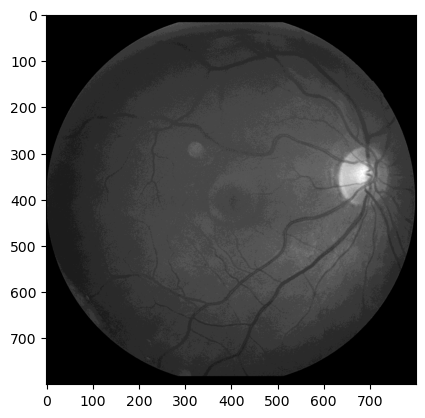

In [67]:
plt.imshow(convert_to_image(img).transpose(1,2,0),cmap='gray')

In [12]:
#|default_exp dataset_utils
#|hide
nbpath = '/home/tiurin/projects/ExampleProject/Temp/code/nbs/dataset_utils.ipynb'
import nbdev; nbdev.nbdev_export(nbpath)